In [1]:
import torch

from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib notebook

In [3]:
cifar_train_set = datasets.CIFAR10('./data/cifar10/', train = True, download = True)
train_input = torch.from_numpy(cifar_train_set.data).permute(0, 3, 1, 2).float()
train_targets = torch.tensor(cifar_train_set.targets, dtype = torch.int64)

mu, std = train_input.mean(), train_input.std()
train_input.sub_(mu).div_(std)

Files already downloaded and verified


tensor([[[[-0.9619, -1.2113, -1.1022,  ...,  0.5813,  0.4878,  0.4254],
          [-1.6322, -1.8816, -1.6011,  ...,  0.0357, -0.0266,  0.0201],
          [-1.4919, -1.6322, -1.1178,  ..., -0.0422, -0.0110, -0.1825],
          ...,
          [ 1.3608,  1.2516,  1.2049,  ...,  0.6125, -1.0087, -1.0555],
          [ 0.9243,  0.8152,  1.0178,  ...,  0.9866, -0.3696, -0.5878],
          [ 0.8775,  0.7372,  0.9087,  ...,  1.4855,  0.4722,  0.0357]],

         [[-0.9152, -1.1646, -1.1334,  ...,  0.1760,  0.0669,  0.0513],
          [-1.5699, -1.8816, -1.7569,  ..., -0.5099, -0.5878, -0.5254],
          [-1.5075, -1.7725, -1.4608,  ..., -0.5722, -0.5722, -0.7437],
          ...,
          [ 0.7684,  0.5034,  0.6281,  ...,  0.1916, -1.3984, -1.3516],
          [ 0.2852,  0.0357,  0.3631,  ...,  0.4254, -0.9152, -1.0555],
          [ 0.3631,  0.1293,  0.3319,  ...,  0.9866, -0.0422, -0.4475]],

         [[-0.8996, -1.1802, -1.2113,  ..., -0.1981, -0.2916, -0.2760],
          [-1.5699, -1.8816, -

In [4]:
class ResNetBlock(nn.Module):
    def __init__(self, nb_channels, kernel_size,
                skip_connections = True,
                batch_normalization = True):
        super().__init__()

        self.conv1 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)
        self.bn1 = nn.BatchNorm2d(nb_channels)

        self.conv2 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)
        self.bn2 = nn.BatchNorm2d(nb_channels)

        # options
        self.batch_normalization = batch_normalization
        self.skip_connections = skip_connections

    def forward(self, x):
        y = self.conv1(x)
        if self.batch_normalization:
            y = self.bn1(y)
        y = F.relu(y)

        y = self.conv2(y)
        if self.batch_normalization:
            y = self.bn2(y)

        # is this right?
        if self.skip_connections:
            y = y + x
        y = F.relu(y)

        return y

In [5]:
class ResNet(nn.Module):

    def __init__(self, nb_residual_blocks, nb_channels,
                 kernel_size = 3, nb_classes = 10,
                 skip_connections = True,
                 batch_normalization = True):
        super().__init__()

        self.conv = nn.Conv2d(3, nb_channels,
                              kernel_size = kernel_size,
                              padding = (kernel_size - 1) // 2)
        self.bn = nn.BatchNorm2d(nb_channels)

        self.resnet_blocks = nn.Sequential(
            *(ResNetBlock(nb_channels, kernel_size,
                          skip_connections=skip_connections,
                          batch_normalization=batch_normalization)
              for _ in range(nb_residual_blocks))
        )

        self.fc = nn.Linear(nb_channels, nb_classes)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.resnet_blocks(x)
        x = F.avg_pool2d(x, 32).view(x.size(0), -1)
        x = self.fc(x)
        return x

# Example 
Plot the norm of the weights of first conv layer of each block

In [6]:
model = ResNet(30, 10, kernel_size=3, nb_classes=10, batch_normalization=True)
monitored_parameters = [b.conv1.weight for b in model.resnet_blocks]
wnorm = torch.tensor([w.norm() for w in monitored_parameters])

<IPython.core.display.Javascript object>


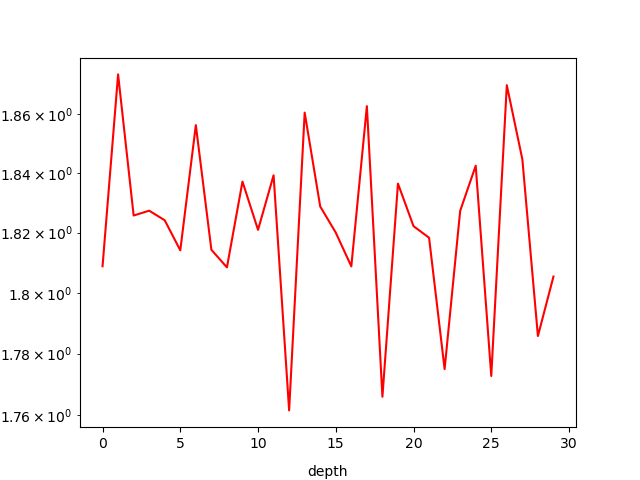

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlabel('depth', labelpad=10)
ax.set_yscale('log')
ax.set_ylabel('weight norm', labelpad=10)

ax.plot(wnorm.numpy(), color='red')

plt.show()

# Gradient norm 

In [33]:
def get_stats(skip_connections, 
             batch_normalization):
    model = ResNet(30, 10, kernel_size=3, 
                  skip_connections=skip_connections, 
                  batch_normalization=batch_normalization)
    pred = model(train_input[:100])
    criterion = nn.CrossEntropyLoss()
    loss = criterion(pred, train_targets[:100])
    # key 
    model.zero_grad()
    loss.backward()
    weight_grads = torch.tensor([b.conv1.weight.grad.norm()
                                for b in model.resnet_blocks])
    return weight_grads

In [34]:
import itertools

In [35]:
combinations = list(itertools.product([True, False], repeat=2))

In [36]:
s_labels = ["skip="+str(x[0]) for x in combinations]
b_labels = ["norm="+str(x[1]) for x in combinations]

In [37]:
labels = []
for i in range(len(s_labels)):
    labels.append(s_labels[i] + ", " + b_labels[i])

In [38]:
weight_grad_list = []

In [39]:
for i, (s, b) in enumerate(combinations):
    weight_grad_list.append(get_stats(s, b))

<IPython.core.display.Javascript object>


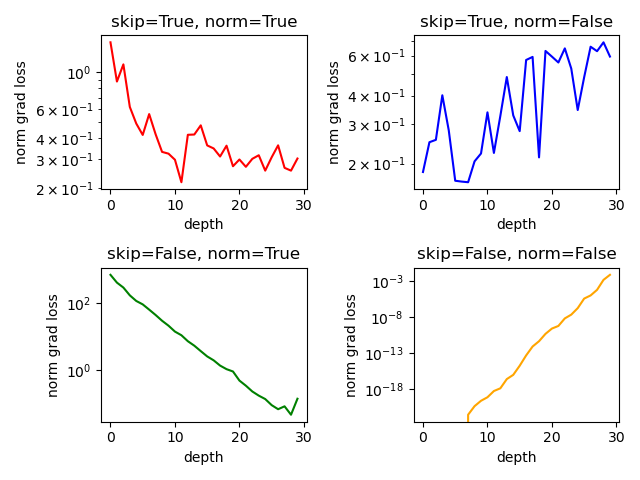

In [40]:
fig1, axes = plt.subplots(nrows=2, ncols=2)

for a in axes.flat:
    a.set_yscale('log')

axes[0,0].set_title(labels[0])
axes[0,0].plot(weight_grad_list[0], color="red")
axes[0,1].set_title(labels[1])
axes[0,1].plot(weight_grad_list[1], color="blue")
axes[1,0].set_title(labels[2])
axes[1,0].plot(weight_grad_list[2], color="green")
axes[1,1].set_title(labels[3])
axes[1,1].plot(weight_grad_list[3], color="orange")

for ax in axes.flat:
    ax.set_xlabel("depth")
    ax.set_ylabel("norm grad loss")

plt.tight_layout()
#plt.savefig("norm_grad_loss_weights.png", dpi=300)
plt.show()

<IPython.core.display.Javascript object>


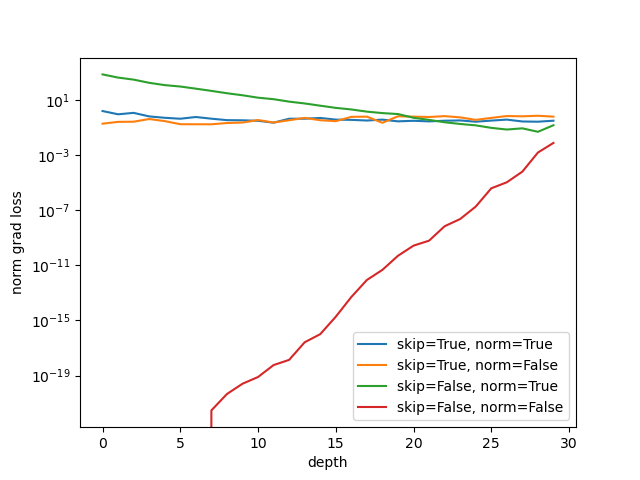

In [41]:
fig2, ax2 = plt.subplots(nrows=1, ncols=1)
for i in range(len(weight_grad_list)):
    ax2.plot(weight_grad_list[i], label=labels[i])

ax2.set_yscale('log')
ax2.set_xlabel('depth')
ax2.set_ylabel('norm grad loss')
plt.legend()
plt.show()